# TFM con la base de datos de Phisionet

## Preprocesado de los datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import keras as keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, Flatten
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import  compute_class_weight

Importación del dataset con pandas

In [2]:
df = pd.read_excel('df_phisionet.xlsx')
print(df.head())

   subject_id  study_id  cart_id            ecg_time       report_0  \
0    10000032  40689238  6848296 2180-07-23 08:44:00  Ritmo sinusal   
1    10000032  44458630  6848296 2180-07-23 09:54:00  Ritmo sinusal   
2    10000032  49036311  6376932 2180-08-06 09:07:00    Taquicardia   
3    10000117  45090959  6214760 2181-03-04 17:14:00  Ritmo sinusal   
4    10000560  41445586  6852956 2189-10-03 12:54:00  Ritmo sinusal   

  Grupo_Edad     bandwidth                    filtering  rr_interval  p_onset  \
0     Adulto  0.005-150 Hz  60 Hz notch Baseline filter          659       40   
1     Adulto  0.005-150 Hz  60 Hz notch Baseline filter          722       40   
2     Adulto  0.005-150 Hz  60 Hz notch Baseline filter          600       40   
3     Adulto  0.005-150 Hz  60 Hz notch Baseline filter          659       40   
4     Adulto  0.005-150 Hz  60 Hz notch Baseline filter          952       40   

   p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  t_axis  
0    128        170   

Se eliminaron las variables pertenecientes a los IDs tanto de los pacientes como de los ECG, ya que no aportaban nada al análisis.

In [3]:
# Eliminación de los ID
df = df.drop(columns=['subject_id', 'study_id', 'cart_id'])
print(df.columns)

Index(['ecg_time', 'report_0', 'Grupo_Edad', 'bandwidth', 'filtering',
       'rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end',
       'p_axis', 'qrs_axis', 't_axis'],
      dtype='object')


Una vez eliminadas dichas variables, se procedió a realizar un análisis exploratorio de los datos.

In [4]:
# Dimensiones del dataset
print(df.shape)

(625975, 14)


In [5]:
# Tipo de datos de cada columna
print(df.dtypes)

ecg_time       datetime64[ns]
report_0               object
Grupo_Edad             object
bandwidth              object
filtering              object
rr_interval             int64
p_onset                 int64
p_end                   int64
qrs_onset               int64
qrs_end                 int64
t_end                   int64
p_axis                  int64
qrs_axis                int64
t_axis                  int64
dtype: object


In [6]:
# Visualización de las 10 primeras y últimas filas
print('10 PRIMERAS FILAS')
print(df.head(10))
print('10 ÚLTIMAS FILAS')
print(df.tail(10))

10 PRIMERAS FILAS
             ecg_time       report_0 Grupo_Edad     bandwidth  \
0 2180-07-23 08:44:00  Ritmo sinusal     Adulto  0.005-150 Hz   
1 2180-07-23 09:54:00  Ritmo sinusal     Adulto  0.005-150 Hz   
2 2180-08-06 09:07:00    Taquicardia     Adulto  0.005-150 Hz   
3 2181-03-04 17:14:00  Ritmo sinusal     Adulto  0.005-150 Hz   
4 2189-10-03 12:54:00  Ritmo sinusal     Adulto  0.005-150 Hz   
5 2198-09-19 10:01:00  Ritmo sinusal     Adulto  0.005-150 Hz   
6 2136-06-19 07:24:00  Ritmo sinusal     Adulto  0.005-150 Hz   
7 2136-07-05 12:35:00  Ritmo sinusal     Adulto  0.005-150 Hz   
8 2137-02-07 13:58:00    Bradicardia     Adulto  0.005-150 Hz   
9 2142-03-23 14:09:00    Bradicardia     Adulto  0.005-150 Hz   

                     filtering  rr_interval  p_onset  p_end  qrs_onset  \
0  60 Hz notch Baseline filter          659       40    128        170   
1  60 Hz notch Baseline filter          722       40    124        162   
2  60 Hz notch Baseline filter          600 

In [7]:
# Valores nulos
print(df.isnull().sum())

ecg_time       0
report_0       0
Grupo_Edad     0
bandwidth      0
filtering      0
rr_interval    0
p_onset        0
p_end          0
qrs_onset      0
qrs_end        0
t_end          0
p_axis         0
qrs_axis       0
t_axis         0
dtype: int64


In [8]:
# NAs
print(df.isna().any())

ecg_time       False
report_0       False
Grupo_Edad     False
bandwidth      False
filtering      False
rr_interval    False
p_onset        False
p_end          False
qrs_onset      False
qrs_end        False
t_end          False
p_axis         False
qrs_axis       False
t_axis         False
dtype: bool


In [9]:
# Descriptiva de los datos
print(df.describe())

                            ecg_time    rr_interval        p_onset  \
count                         625975  625975.000000  625975.000000   
mean   2155-10-02 21:35:10.433898496     822.910747    4544.841008   
min              2087-05-08 00:05:00     235.000000       0.000000   
25%              2135-09-26 02:05:00     689.000000      40.000000   
50%              2155-09-12 09:08:00     810.000000      40.000000   
75%              2175-11-11 13:10:00     952.000000      40.000000   
max              2224-04-14 02:31:00    5454.000000   29999.000000   
std                              NaN     196.179283   10708.280224   

              p_end      qrs_onset        qrs_end          t_end  \
count  625975.00000  625975.000000  625975.000000  625975.000000   
mean     4637.13556     200.717503     299.341272     598.426806   
min        28.00000       0.000000       0.000000     235.000000   
25%       140.00000     184.000000     272.000000     558.000000   
50%       154.00000     200.0

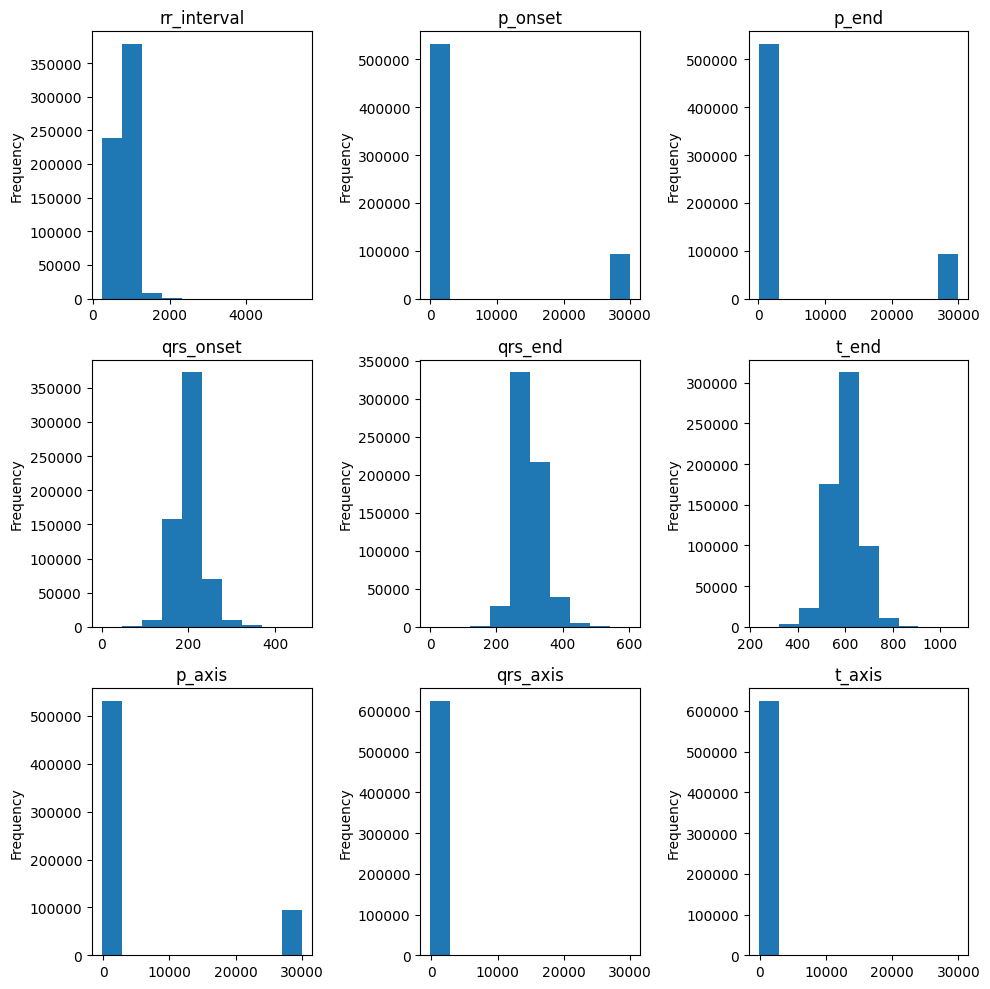

In [10]:
# Histograma para cada variable de las señales
fig, ax = plt.subplots(ncols=3, nrows=3, figsize = (10,10))
ax = ax.flatten()
df['rr_interval'].plot(kind='hist', title='rr_interval',ax=ax[0])
df['p_onset'].plot(kind='hist', title='p_onset',ax=ax[1])
df['p_end'].plot(kind='hist', title='p_end',ax=ax[2])
df['qrs_onset'].plot(kind='hist', title='qrs_onset',ax=ax[3])
df['qrs_end'].plot(kind='hist', title='qrs_end',ax=ax[4])
df['t_end'].plot(kind='hist', title='t_end',ax=ax[5])
df['p_axis'].plot(kind='hist', title='p_axis',ax=ax[6])
df['qrs_axis'].plot(kind='hist', title='qrs_axis',ax=ax[7])
df['t_axis'].plot(kind='hist', title='t_axis',ax=ax[8])
plt.tight_layout()
plt.show()

Observación de la relación entre las variables.

In [11]:
# Selección de las variables numéricas
variables_numericas = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
df_numerico = df[variables_numericas]

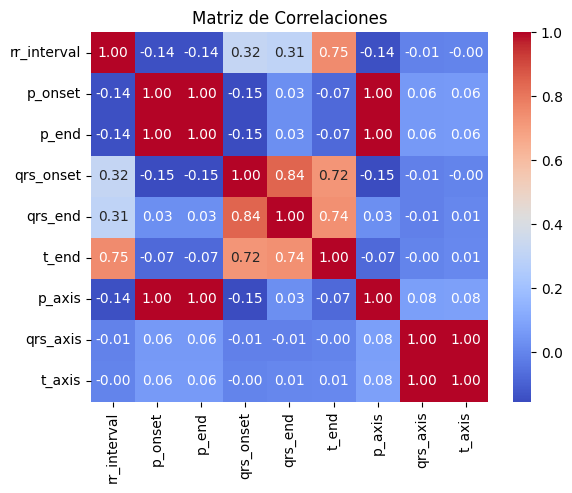

In [12]:
# Matriz de correlaciones
matriz_correlaciones = df_numerico.corr()
plt.figure()
sns.heatmap(matriz_correlaciones, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlaciones')
plt.show()

Observando las relaciones, se puede ver que hay algunas variables que están altamente correlacionadas entre sí, como las variables p_end y p_onset, p_axis y p_end, p_onset y p_end con qrs_axis y la variable qrs_axis con t_axis.

Categorización de las variables independientes categóricas.

In [13]:
print(df['report_0'].unique())
print(df['Grupo_Edad'].unique())
print(df['bandwidth'].unique())
print(df['filtering'].unique())

['Ritmo sinusal' 'Taquicardia' 'Bradicardia' 'Fibrilacion auricular'
 'Marcapasos']
['Adulto' 'Niño']
['0.005-150 Hz' '0.05-150 Hz' '0.0005-150 Hz']
['60 Hz notch Baseline filter' 'Baseline filter'
 '50 Hz notch Baseline filter']


In [14]:
# Categorizador
categorizador = LabelEncoder()
# Aplicar a las variables categóricas
df['report_0'] = categorizador.fit_transform(df['report_0'])
df['Grupo_Edad'] = categorizador.fit_transform(df['Grupo_Edad'])
df['bandwidth'] = categorizador.fit_transform(df['bandwidth'])
df['filtering'] = categorizador.fit_transform(df['filtering'])

In [15]:
print(df['report_0'].unique())
print(df['Grupo_Edad'].unique())
print(df['bandwidth'].unique())
print(df['filtering'].unique())

[3 4 0 1 2]
[0 1]
[1 2 0]
[1 2 0]


Antes de proceder con los análisis, se va a proceder a almacenar las variables independientes numéricas en la variable X, y la dependiente categórica en Y. 
Además de realizar las divisiones en conjuntos de entrenamiento y test.

In [16]:
X = df.drop(columns=['report_0','ecg_time'])
Y = df.loc[:, 'report_0']

División en conjuntos de entrenamiento y test.

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.25, random_state= 0)

Escalado de las variables

In [18]:
# Normaliazción de los datos
escalador = StandardScaler()
X_train = escalador.fit_transform(X_train)
X_test = escalador.transform(X_test)

Creación de las funciones para obtener las métricas de Sensibilidad y Especificidad.

In [19]:
# Funciones para el cálculo de la Sensibilidad y Especificidad para cualquier matriz
# VP (Verdaderos positivos)
def VP(matriz_confusion):
    diagonal = []
    for elemento in range(len(matriz_confusion)):
        diagonal.append(matriz_confusion[elemento][elemento])
    return sum(diagonal)

# FN (falsos negativos)
def FN(matriz_confusion):
    fuera_diagonal = []
    for fila in range(len(matriz_confusion)):
        for columna in range(len(matriz_confusion)):
            if fila != columna:
                fuera_diagonal.append(matriz_confusion[fila][columna])
    return sum(fuera_diagonal)

# FP (falsos positivos)
def FP(matriz_confusion):
    fuera_diagonal = []
    for fila in range(len(matriz_confusion)):
        for columna in range(len(matriz_confusion)):
            if fila != columna:
                fuera_diagonal.append(matriz_confusion[fila][columna])
    return sum(fuera_diagonal)

# VN (verdaderos negativos)
def VN(matriz_confusion):
    VN = []
    i = 0
    while i < len(matriz_confusion):
        for fila in range(len(matriz_confusion)):
            for columna in range(len(matriz_confusion)):
                if  fila != i and columna != i:
                    VN.append(matriz_confusion[fila][columna])
        i += 1
    return sum(VN)

# Sensibilidad 
def Sensibilidad(matriz_confusion):
    return VP(matriz_confusion) / (VP(matriz_confusion) + FN(matriz_confusion))

# Especificidad
def Especificidad(matriz_confusion):
    return VN(matriz_confusion) / (VN(matriz_confusion) + FP(matriz_confusion))

## Random Forest

Creación y entrenamiento del predictor.

In [20]:
clasificador = RandomForestClassifier(n_estimators=100,criterion = 'entropy',random_state = 0)
clasificador.fit(X_train,Y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

Obtención de las métricas de evaluación del modelo.

In [21]:
# Predicción 
y_prediccion = clasificador.predict(X_test)

# Accuracy
Accuracy_Random_Forest = accuracy_score(Y_test, y_prediccion)
print(f'Accuracy del Random Forest: {Accuracy_Random_Forest}')

# Matriz de confusión
Matriz_Confusion_Random_Forest = confusion_matrix(Y_test, y_prediccion)
print('Matriz de confusión del Random Forest:')
print(Matriz_Confusion_Random_Forest)

# Precisión
Precision = precision_score(Y_test, y_prediccion, average='weighted')
print(f'Precisión del Random Forest: {Precision}')

# Recall
Recall = recall_score(Y_test, y_prediccion, average='weighted')
print(f'Recall del Random Forest: {Recall}')

# F1 Score
F1 = f1_score(Y_test, y_prediccion, average='weighted')
print(f'F1 del Random Forest: {F1}')

Accuracy del Random Forest: 0.965806995795366
Matriz de confusión del Random Forest:
[[22701    23     0   529     0]
 [    0 16646  1033     0   187]
 [   37  1655  3334   276     2]
 [  828     1     2 94548   385]
 [    1   323     0    69 13914]]
Precisión del Random Forest: 0.9650276195216043
Recall del Random Forest: 0.965806995795366
F1 del Random Forest: 0.9651372820567918


In [22]:
# Sensibilidad
sensibilidad = Sensibilidad(Matriz_Confusion_Random_Forest)
print(f'Sensibilidad: {round(sensibilidad,4)}')
# Especificidad
especificidad = Especificidad(Matriz_Confusion_Random_Forest)
print(f'Especificidad: {round(especificidad,4)}')

Sensibilidad: 0.9658
Especificidad: 0.9915


## Selección de las variables

In [23]:
significacion_variables = clasificador.feature_importances_
nombres_variables = X.columns.tolist()

Representación de la significación para ver qué variables entran en el modelo final.

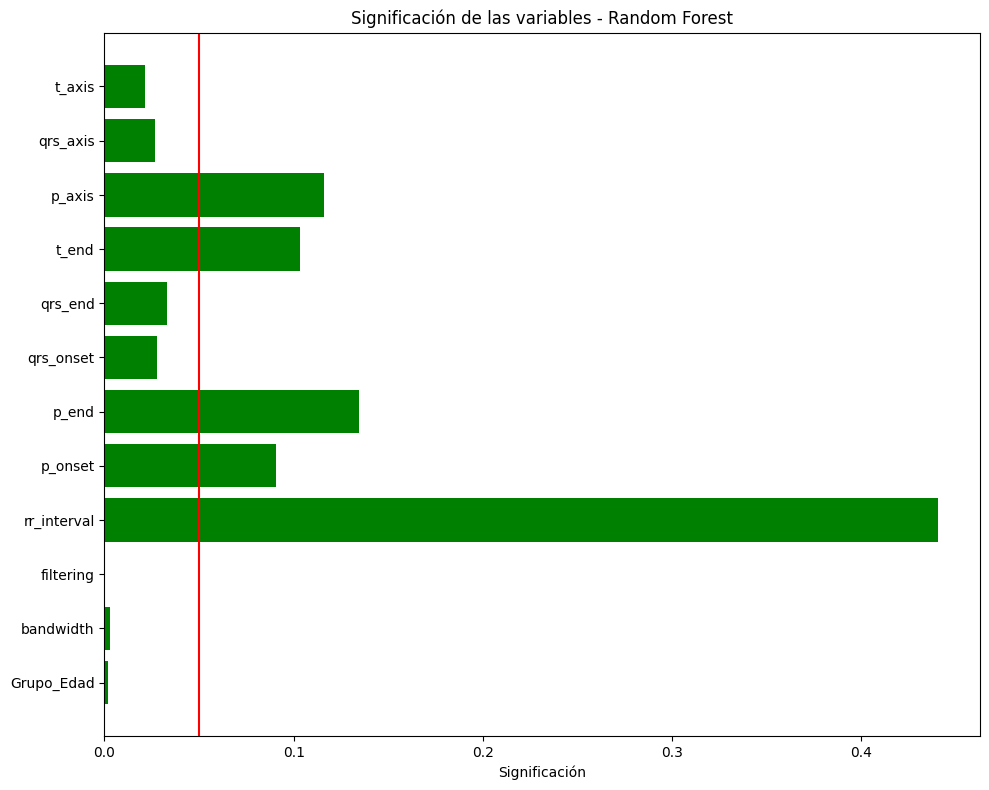

In [24]:
plt.figure(figsize=(10,8))
plt.barh(nombres_variables,significacion_variables, color = 'green')
plt.axvline(x=0.05,color = 'red')
plt.xlabel('Significación')
plt.title('Significación de las variables - Random Forest')
plt.tight_layout()
plt.show()

In [25]:
print(nombres_variables)

['Grupo_Edad', 'bandwidth', 'filtering', 'rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']


Ajuste del modelo sin la variable 'rr_interval', que es la menos significativa.

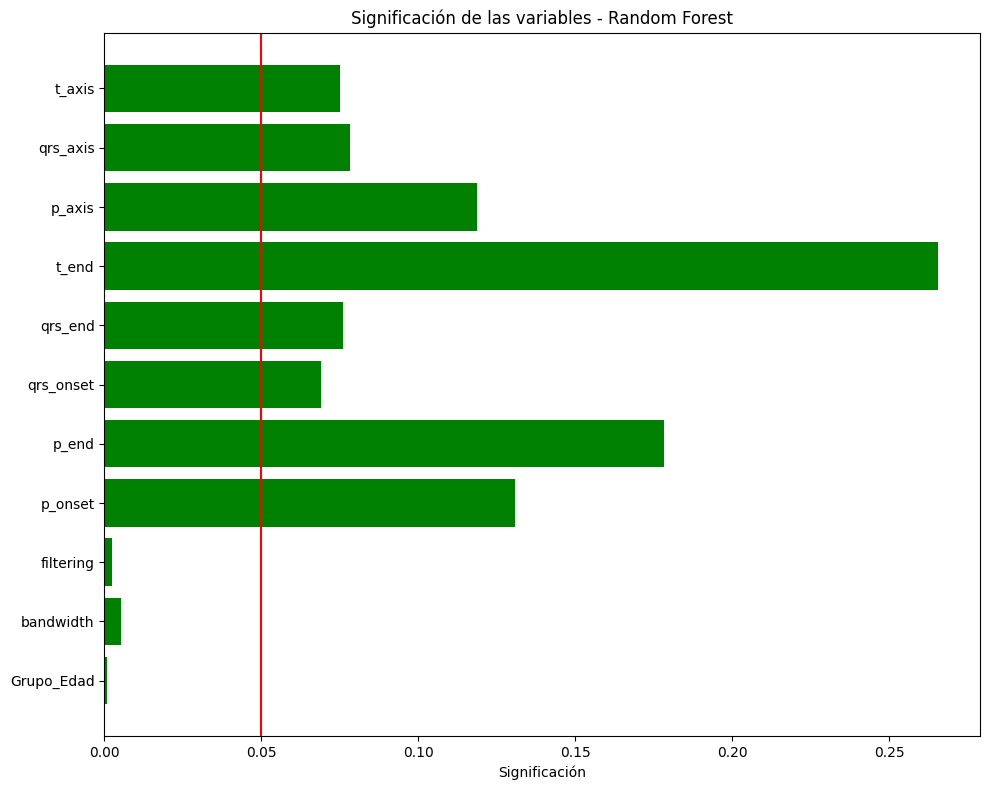

In [26]:
X_train = np.delete(X_train, 3, axis=1)
X_test = np.delete(X_test, 3, axis=1)
X = X.drop(columns=['rr_interval'])

clasificador = RandomForestClassifier(n_estimators=100,criterion = 'entropy',random_state = 0)
clasificador.fit(X_train,Y_train)

y_prediccion = clasificador.predict(X_test)
significacion_variables = clasificador.feature_importances_
nombres_variables = X.columns.tolist()

plt.figure(figsize=(10,8))
plt.barh(nombres_variables,significacion_variables, color = 'green')
plt.axvline(x=0.05,color = 'red')
plt.xlabel('Significación')
plt.title('Significación de las variables - Random Forest')
plt.tight_layout()
plt.show()

In [27]:
print(nombres_variables)

['Grupo_Edad', 'bandwidth', 'filtering', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']


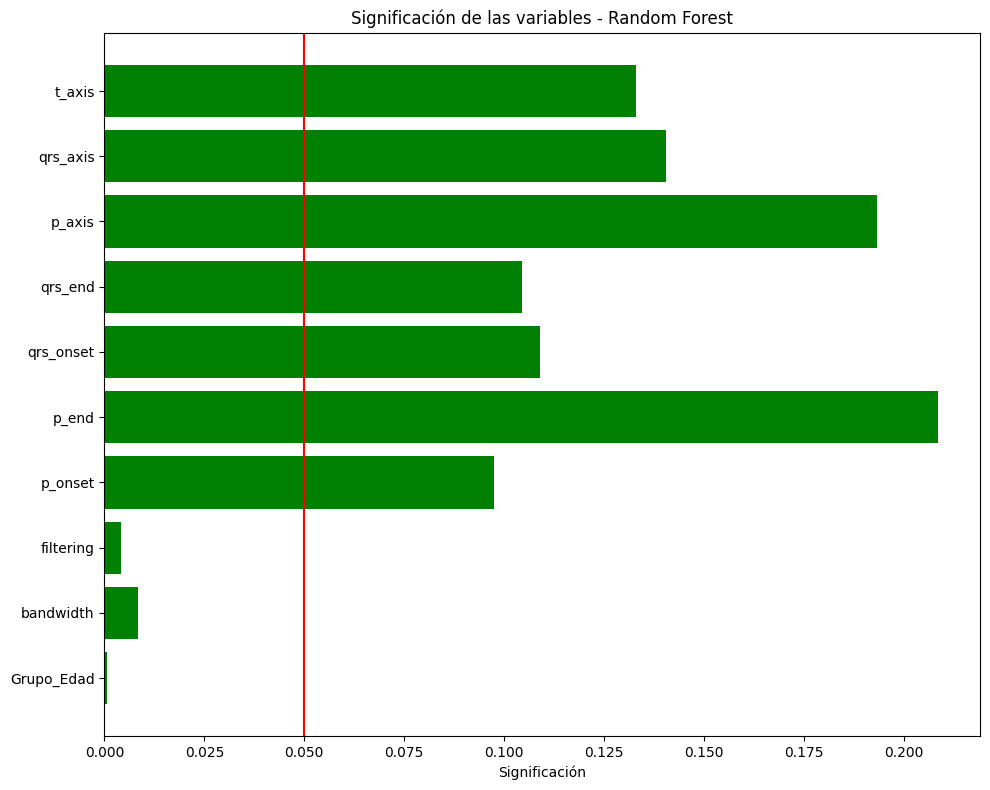

In [28]:
X_train = np.delete(X_train, 7, axis=1)
X_test = np.delete(X_test, 7, axis=1)
X = X.drop(columns=['t_end'])

clasificador = RandomForestClassifier(n_estimators=100,criterion = 'entropy',random_state = 0)
clasificador.fit(X_train,Y_train)

y_prediccion = clasificador.predict(X_test)
significacion_variables = clasificador.feature_importances_
nombres_variables = X.columns.tolist()

plt.figure(figsize=(10,8))
plt.barh(nombres_variables,significacion_variables, color = 'green')
plt.axvline(x=0.05,color = 'red')
plt.xlabel('Significación')
plt.title('Significación de las variables - Random Forest')
plt.tight_layout()
plt.show()

In [29]:
print(nombres_variables)

['Grupo_Edad', 'bandwidth', 'filtering', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis']


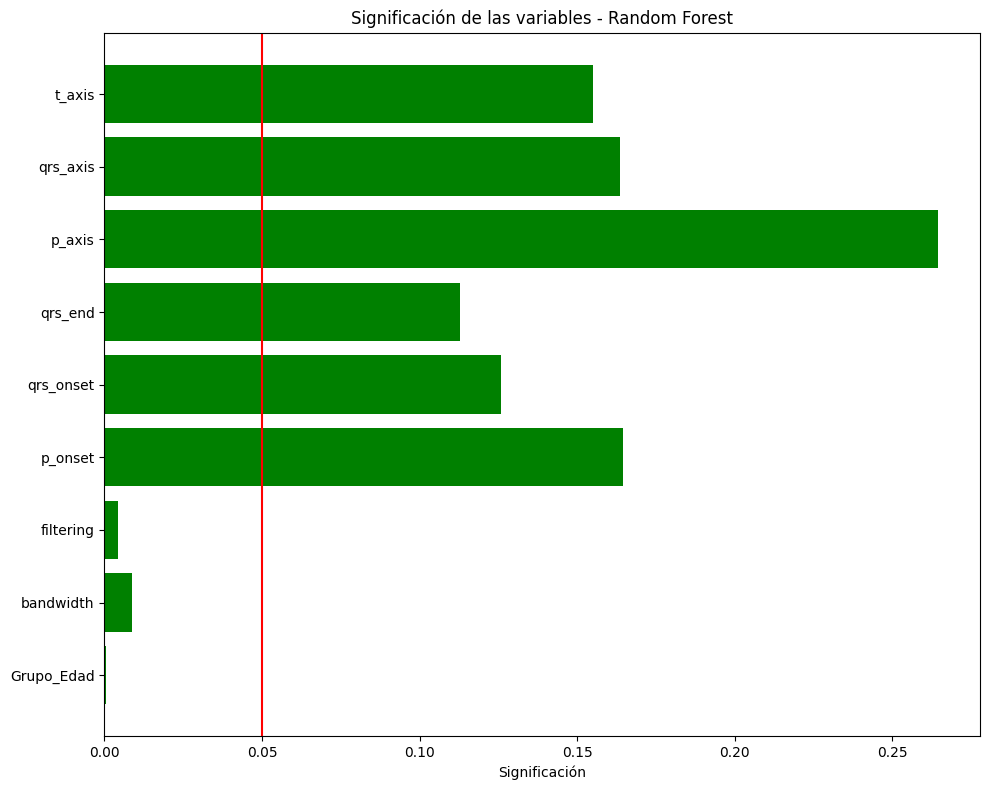

In [30]:
X_train = np.delete(X_train, 4, axis=1)
X_test = np.delete(X_test, 4, axis=1)
X = X.drop(columns=['p_end'])

clasificador = RandomForestClassifier(n_estimators=100,criterion = 'entropy',random_state = 0)
clasificador.fit(X_train,Y_train)

y_prediccion = clasificador.predict(X_test)
significacion_variables = clasificador.feature_importances_
nombres_variables = X.columns.tolist()

plt.figure(figsize=(10,8))
plt.barh(nombres_variables,significacion_variables, color = 'green')
plt.axvline(x=0.05,color = 'red')
plt.xlabel('Significación')
plt.title('Significación de las variables - Random Forest')
plt.tight_layout()
plt.show()

In [31]:
print(nombres_variables)

['Grupo_Edad', 'bandwidth', 'filtering', 'p_onset', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis']


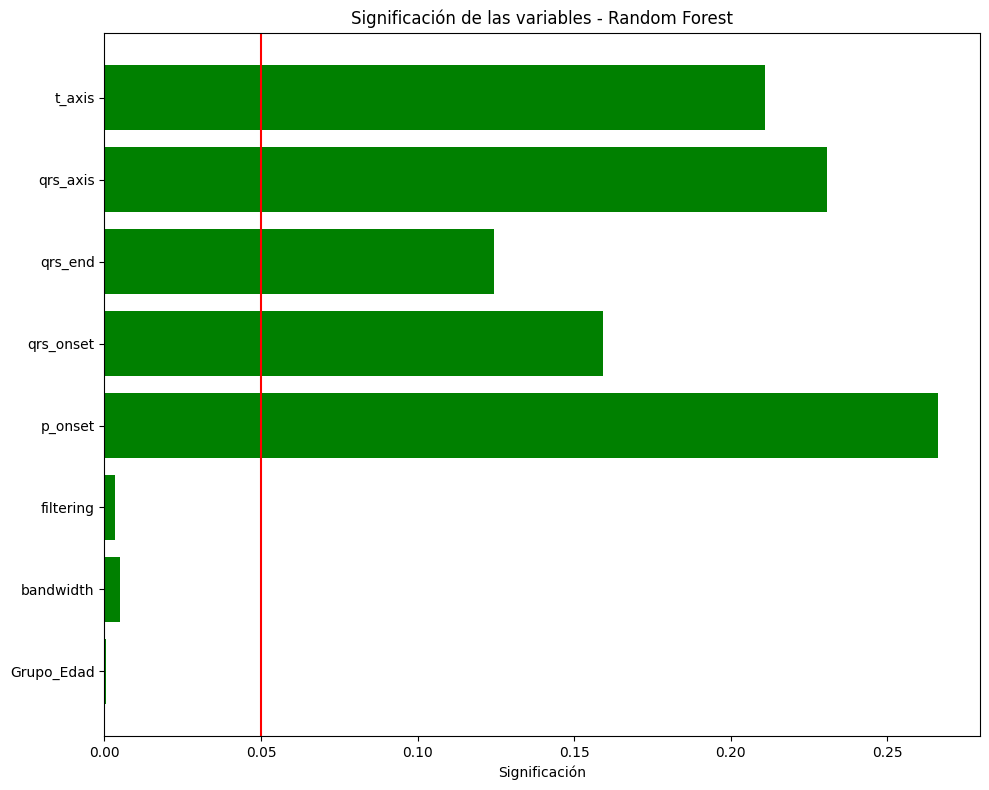

In [32]:
X_train = np.delete(X_train, 6, axis=1)
X_test = np.delete(X_test, 6, axis=1)
X = X.drop(columns=['p_axis'])

clasificador = RandomForestClassifier(n_estimators=100,criterion = 'entropy',random_state = 0)
clasificador.fit(X_train,Y_train)

y_prediccion = clasificador.predict(X_test)
significacion_variables = clasificador.feature_importances_
nombres_variables = X.columns.tolist()

plt.figure(figsize=(10,8))
plt.barh(nombres_variables,significacion_variables, color = 'green')
plt.axvline(x=0.05,color = 'red')
plt.xlabel('Significación')
plt.title('Significación de las variables - Random Forest')
plt.tight_layout()
plt.show()

In [33]:
print(nombres_variables)

['Grupo_Edad', 'bandwidth', 'filtering', 'p_onset', 'qrs_onset', 'qrs_end', 'qrs_axis', 't_axis']


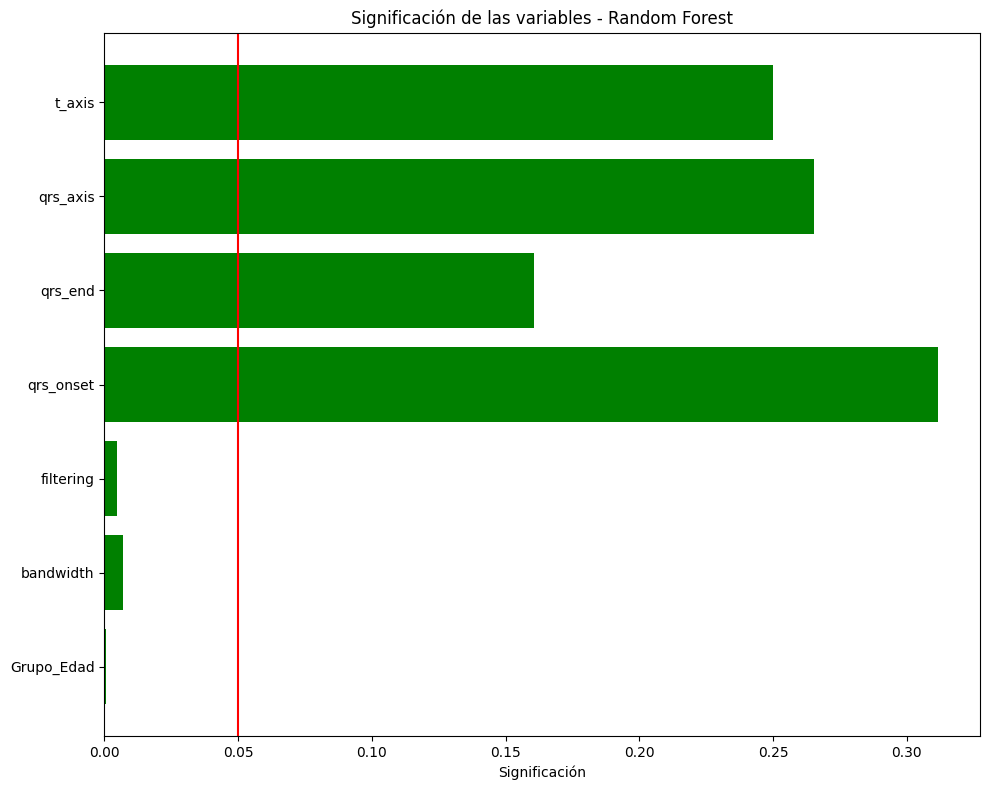

In [34]:
X_train = np.delete(X_train, 3, axis=1)
X_test = np.delete(X_test, 3, axis=1)
X = X.drop(columns=['p_onset'])

clasificador = RandomForestClassifier(n_estimators=100,criterion = 'entropy',random_state = 0)
clasificador.fit(X_train,Y_train)

y_prediccion = clasificador.predict(X_test)
significacion_variables = clasificador.feature_importances_
nombres_variables = X.columns.tolist()

plt.figure(figsize=(10,8))
plt.barh(nombres_variables,significacion_variables, color = 'green')
plt.axvline(x=0.05,color = 'red')
plt.xlabel('Significación')
plt.title('Significación de las variables - Random Forest')
plt.tight_layout()
plt.show()

In [35]:
print(nombres_variables)

['Grupo_Edad', 'bandwidth', 'filtering', 'qrs_onset', 'qrs_end', 'qrs_axis', 't_axis']


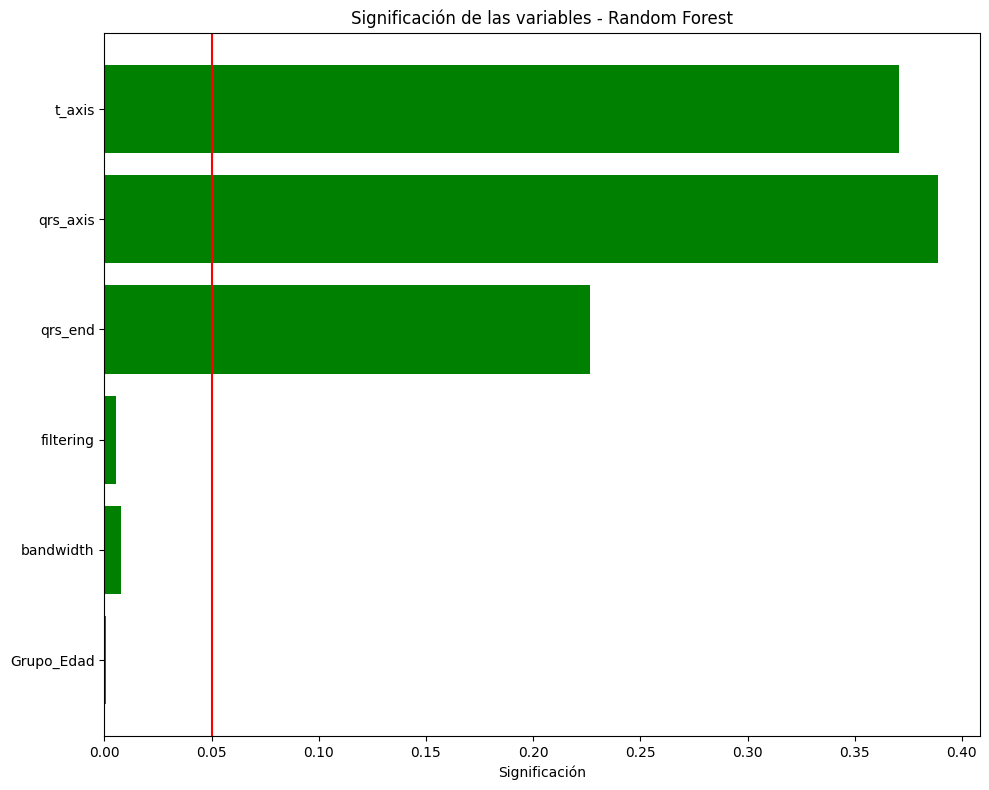

In [36]:
X_train = np.delete(X_train, 3, axis=1)
X_test = np.delete(X_test, 3, axis=1)
X = X.drop(columns=['qrs_onset'])

clasificador = RandomForestClassifier(n_estimators=100,criterion = 'entropy',random_state = 0)
clasificador.fit(X_train,Y_train)

y_prediccion = clasificador.predict(X_test)
significacion_variables = clasificador.feature_importances_
nombres_variables = X.columns.tolist()

plt.figure(figsize=(10,8))
plt.barh(nombres_variables,significacion_variables, color = 'green')
plt.axvline(x=0.05,color = 'red')
plt.xlabel('Significación')
plt.title('Significación de las variables - Random Forest')
plt.tight_layout()
plt.show()

In [37]:
print(nombres_variables)

['Grupo_Edad', 'bandwidth', 'filtering', 'qrs_end', 'qrs_axis', 't_axis']


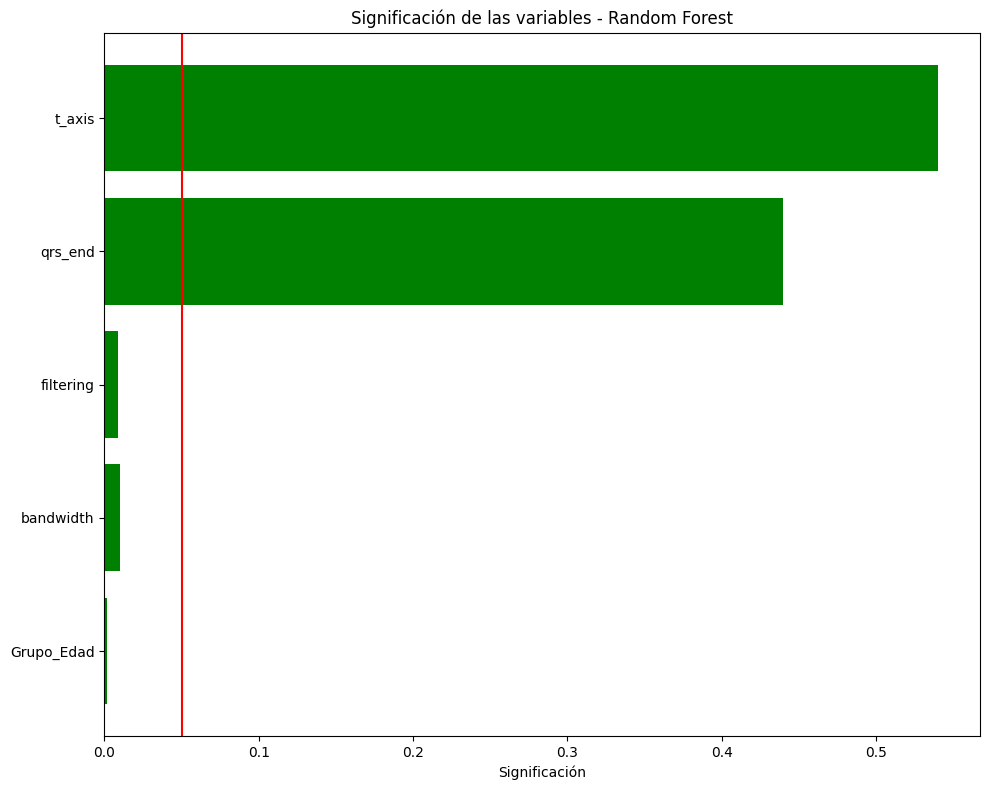

In [38]:
X_train = np.delete(X_train, 4, axis=1)
X_test = np.delete(X_test, 4, axis=1)
X = X.drop(columns=['qrs_axis'])

clasificador = RandomForestClassifier(n_estimators=100,criterion = 'entropy',random_state = 0)
clasificador.fit(X_train,Y_train)

y_prediccion = clasificador.predict(X_test)
significacion_variables = clasificador.feature_importances_
nombres_variables = X.columns.tolist()

plt.figure(figsize=(10,8))
plt.barh(nombres_variables,significacion_variables, color = 'green')
plt.axvline(x=0.05,color = 'red')
plt.xlabel('Significación')
plt.title('Significación de las variables - Random Forest')
plt.tight_layout()
plt.show()

In [39]:
print(nombres_variables)

['Grupo_Edad', 'bandwidth', 'filtering', 'qrs_end', 't_axis']


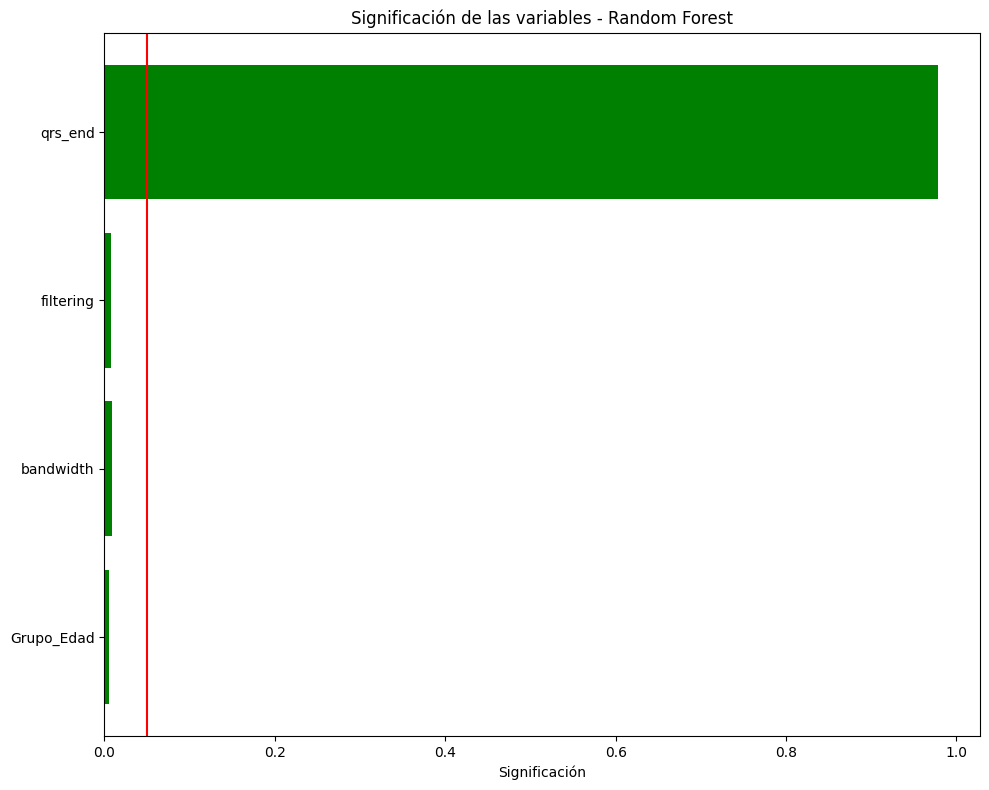

In [40]:
X_train = np.delete(X_train, 4, axis=1)
X_test = np.delete(X_test, 4, axis=1)
X = X.drop(columns=['t_axis'])

clasificador = RandomForestClassifier(n_estimators=100,criterion = 'entropy',random_state = 0)
clasificador.fit(X_train,Y_train)

y_prediccion = clasificador.predict(X_test)
significacion_variables = clasificador.feature_importances_
nombres_variables = X.columns.tolist()

plt.figure(figsize=(10,8))
plt.barh(nombres_variables,significacion_variables, color = 'green')
plt.axvline(x=0.05,color = 'red')
plt.xlabel('Significación')
plt.title('Significación de las variables - Random Forest')
plt.tight_layout()
plt.show()

In [41]:
print(nombres_variables)

['Grupo_Edad', 'bandwidth', 'filtering', 'qrs_end']


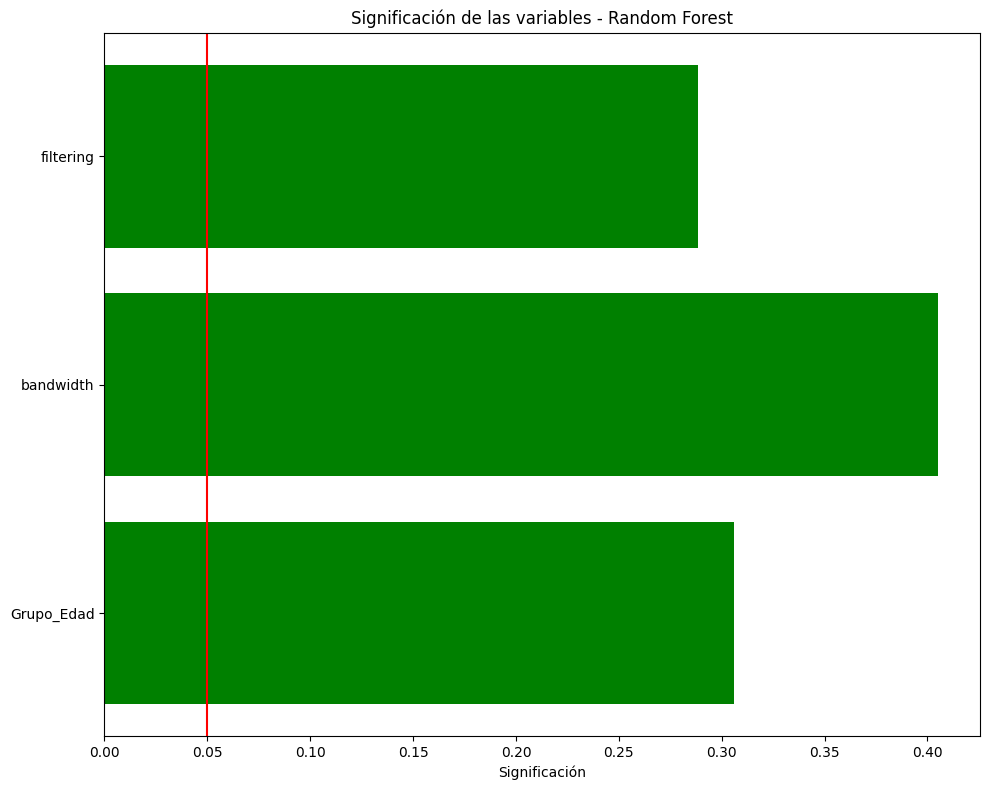

In [42]:
X_train = np.delete(X_train, 3, axis=1)
X_test = np.delete(X_test, 3, axis=1)
X = X.drop(columns=['qrs_end'])

clasificador = RandomForestClassifier(n_estimators=100,criterion = 'entropy',random_state = 0)
clasificador.fit(X_train,Y_train)

y_prediccion = clasificador.predict(X_test)
significacion_variables = clasificador.feature_importances_
nombres_variables = X.columns.tolist()

plt.figure(figsize=(10,8))
plt.barh(nombres_variables,significacion_variables, color = 'green')
plt.axvline(x=0.05,color = 'red')
plt.xlabel('Significación')
plt.title('Significación de las variables - Random Forest')
plt.tight_layout()
plt.show()

In [43]:
print(nombres_variables)

['Grupo_Edad', 'bandwidth', 'filtering']


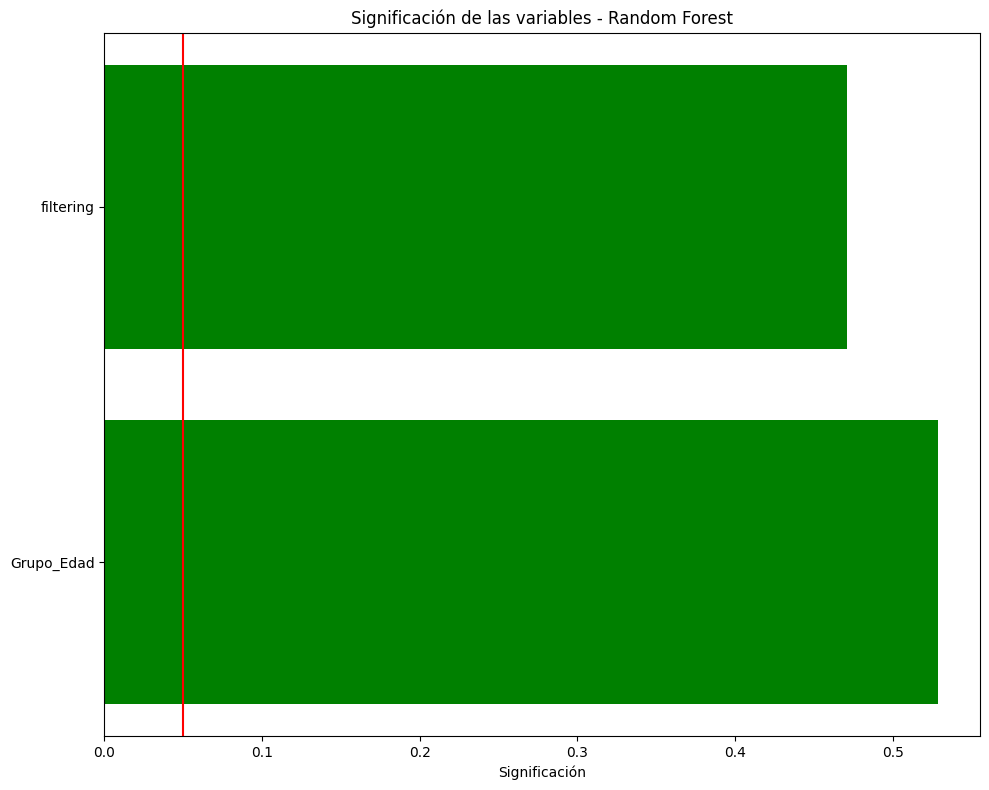

In [44]:
X_train = np.delete(X_train, 1, axis=1)
X_test = np.delete(X_test, 1, axis=1)
X = X.drop(columns=['bandwidth'])

clasificador = RandomForestClassifier(n_estimators=100,criterion = 'entropy',random_state = 0)
clasificador.fit(X_train,Y_train)

y_prediccion = clasificador.predict(X_test)
significacion_variables = clasificador.feature_importances_
nombres_variables = X.columns.tolist()

plt.figure(figsize=(10,8))
plt.barh(nombres_variables,significacion_variables, color = 'green')
plt.axvline(x=0.05,color = 'red')
plt.xlabel('Significación')
plt.title('Significación de las variables - Random Forest')
plt.tight_layout()
plt.show()

In [45]:
print(nombres_variables)

['Grupo_Edad', 'filtering']


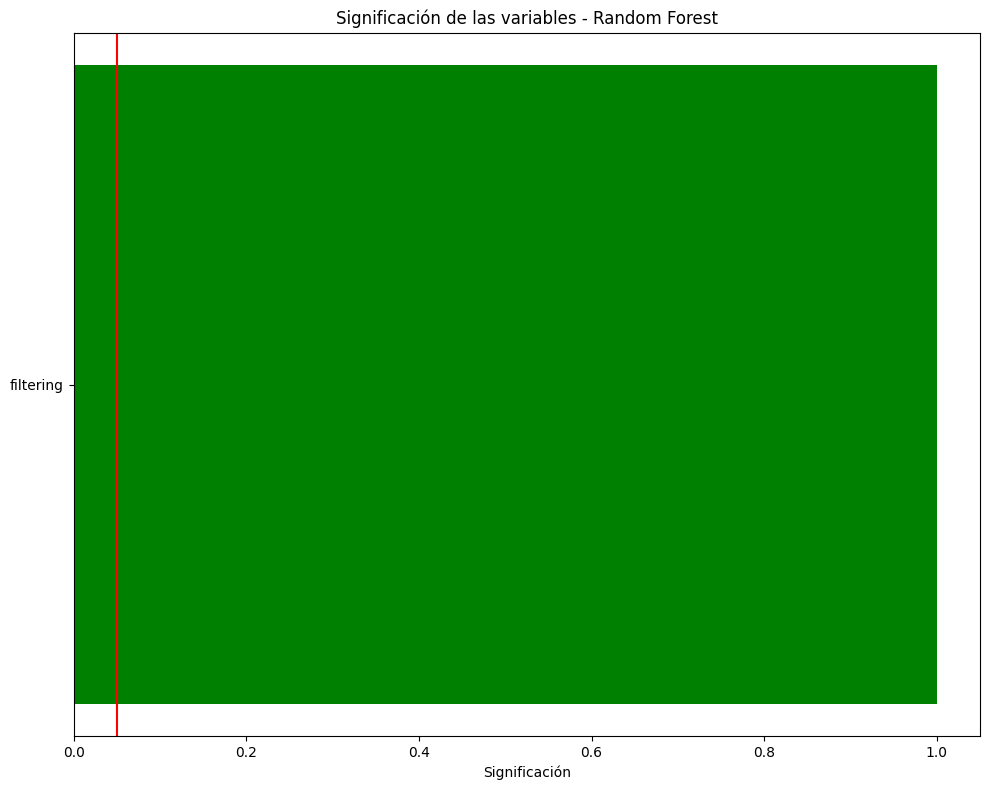

In [46]:
X_train = np.delete(X_train, 0, axis=1)
X_test = np.delete(X_test, 0, axis=1)
X = X.drop(columns=['Grupo_Edad'])

clasificador = RandomForestClassifier(n_estimators=100,criterion = 'entropy',random_state = 0)
clasificador.fit(X_train,Y_train)

y_prediccion = clasificador.predict(X_test)
significacion_variables = clasificador.feature_importances_
nombres_variables = X.columns.tolist()

plt.figure(figsize=(10,8))
plt.barh(nombres_variables,significacion_variables, color = 'green')
plt.axvline(x=0.05,color = 'red')
plt.xlabel('Significación')
plt.title('Significación de las variables - Random Forest')
plt.tight_layout()
plt.show()

Se decidió mantener todas las variables iniciales, debido a que, la eliminación de la menos significativa tiene un impacto lo suficientemente grande como para no eliminarla del modelo, ya que el modelo termina perdiendo todas las variables. Además, la evaluación del modelo que contiene todas las variables entrenado con el Random Forest, tiene una precisión de prácticamente 1, por lo que es muy bueno. Por lo que se procederá a realizar los análisis con todas las variables.

In [47]:
# Importación del dataset
df = pd.read_excel('df_phisionet.xlsx')
print(df.head())

# Eliminación de los ID
df = df.drop(columns=['subject_id', 'study_id', 'cart_id'])
print(df.columns)

print(df['report_0'].unique())
print(df['Grupo_Edad'].unique())
print(df['bandwidth'].unique())
print(df['filtering'].unique())

# Categorizador
categorizador = LabelEncoder()
# Aplicar a las variables categóricas
df['report_0'] = categorizador.fit_transform(df['report_0'])
df['Grupo_Edad'] = categorizador.fit_transform(df['Grupo_Edad'])
df['bandwidth'] = categorizador.fit_transform(df['bandwidth'])
df['filtering'] = categorizador.fit_transform(df['filtering'])

print(df['report_0'].unique())
print(df['Grupo_Edad'].unique())
print(df['bandwidth'].unique())
print(df['filtering'].unique())

X = df.drop(columns=['report_0','ecg_time']).to_numpy()
Y = df.loc[:, 'report_0'].to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.25, random_state= 0)

# Normalización de los datos
escalador = StandardScaler()
X_train = escalador.fit_transform(X_train)
X_test = escalador.transform(X_test)

   subject_id  study_id  cart_id            ecg_time       report_0  \
0    10000032  40689238  6848296 2180-07-23 08:44:00  Ritmo sinusal   
1    10000032  44458630  6848296 2180-07-23 09:54:00  Ritmo sinusal   
2    10000032  49036311  6376932 2180-08-06 09:07:00    Taquicardia   
3    10000117  45090959  6214760 2181-03-04 17:14:00  Ritmo sinusal   
4    10000560  41445586  6852956 2189-10-03 12:54:00  Ritmo sinusal   

  Grupo_Edad     bandwidth                    filtering  rr_interval  p_onset  \
0     Adulto  0.005-150 Hz  60 Hz notch Baseline filter          659       40   
1     Adulto  0.005-150 Hz  60 Hz notch Baseline filter          722       40   
2     Adulto  0.005-150 Hz  60 Hz notch Baseline filter          600       40   
3     Adulto  0.005-150 Hz  60 Hz notch Baseline filter          659       40   
4     Adulto  0.005-150 Hz  60 Hz notch Baseline filter          952       40   

   p_end  qrs_onset  qrs_end  t_end  p_axis  qrs_axis  t_axis  
0    128        170   

## Regresión Logística

Añadimos el término de penalización "l2" que es el de Risge Regression

In [21]:
clasificador = LogisticRegression(penalty="l2",random_state=0,multi_class='multinomial')
clasificador.fit(X_train,Y_train)

c:\Users\sonia\OneDrive\Documentos\ESCRITORIO\3. MASTER\1. TFM\TFM\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sonia\OneDrive\Documentos\ESCRITORIO\3. MASTER\1. TFM\TFM\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=0)

In [22]:
# Predicción 
y_prediccion = clasificador.predict(X_test)

# Accuracy
Accuracy_Regresion_Logistica = accuracy_score(Y_test, y_prediccion)
print(f'Accuracy de la Regresión Logística: {Accuracy_Regresion_Logistica}')

# Matriz de confusión
Matriz_Confusion_Regresion_Logistica = confusion_matrix(Y_test, y_prediccion)
print('Matriz de confusión de la Regresión Logística:')
print(Matriz_Confusion_Regresion_Logistica)

# Precisión
Precision = precision_score(Y_test, y_prediccion, average='weighted')
print(f'Precisión de la Regresión Logística: {Precision}')

# Recall
Recall = recall_score(Y_test, y_prediccion, average='weighted')
print(f'Recall de la Regresión Logística: {Recall}')

# F1 Score
F1 = f1_score(Y_test, y_prediccion, average='weighted')
print(f'F1 de la Regresión Logística: {F1}')

Accuracy de la Regresión Logística: 0.9559024627142255
Matriz de confusión de la Regresión Logística:
[[22425    21     2   805     0]
 [    9 16295  1284     0   278]
 [   41  2322  2661   278     2]
 [  776     1     5 94648   334]
 [    1   438     0   304 13564]]
Precisión de la Regresión Logística: 0.9541978232618816
Recall de la Regresión Logística: 0.9559024627142255
F1 de la Regresión Logística: 0.9545139707381307


In [23]:
# Sensibilidad
sensibilidad = Sensibilidad(Matriz_Confusion_Regresion_Logistica)
print(f'Sensibilidad: {round(sensibilidad,4)}')
# Especificidad
especificidad = Especificidad(Matriz_Confusion_Regresion_Logistica)
print(f'Especificidad: {round(especificidad,4)}')

Sensibilidad: 0.9559
Especificidad: 0.989


Categorización de la variable objetivo

In [51]:
Y = to_categorical(Y, num_classes=5)

## LSTM básica

Crear el número de pasos temporales. Se iniciará en 5 para realizar el primer entrenamiento de la red y observar los resultados que devuelve.

In [52]:
ventana = 5
x = []
y = []
for i in range(ventana,len(X)):
  x.append(X[i-ventana:i,:])
  y.append(Y[i])

# Conversión de x e y en arrays de numpy para que la red neuronal los coja correctamente.
x,y = np.array(x), np.array(y)


# División en conjuntos de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.25, random_state= 0)

Creación de la red neuronal

In [53]:
red = Sequential()

# Primera capa
red.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
red.add(Dropout(0.1))

# Segunda capa
red.add(LSTM(units = 100, return_sequences = False))
red.add(Dropout(0.1))
red.add(Dense(units = 5,activation = 'softmax'))

# Compilación de la red
red.compile(optimizer = 'adam',loss='CategoricalCrossentropy',metrics = ['accuracy'])

# Entrenamiento de la red
red.fit(x_train,y_train,epochs = 100, batch_size = 32)

# Predicción
y_pred = red.predict(x_test)

# Evaluación del modelo
perdida, accuracy = red.evaluate(x_test,y_test)
print(f'Pérdida del conjunto de test: {perdida}')
print('Accuracy del conjunto de test: ',accuracy)

Epoch 1/100


c:\Users\sonia\OneDrive\Documentos\ESCRITORIO\3. MASTER\1. TFM\TFM\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14672/14672 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - accuracy: 0.6469 - loss: 0.9735
Epoch 2/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 89s 6ms/step - accuracy: 0.6519 - loss: 0.9537
Epoch 3/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step - accuracy: 0.6505 - loss: 0.9537
Epoch 4/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step - accuracy: 0.6530 - loss: 0.9501
Epoch 5/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 89s 6ms/step - accuracy: 0.6524 - loss: 0.9492
Epoch 6/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step - accuracy: 0.6523 - loss: 0.9473
Epoch 7/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 89s 6ms/step - accuracy: 0.6534 - loss: 0.9454
Epoch 8/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step - accuracy: 0.6534 - loss: 0.9462
Epoch 9/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step - accuracy: 0.6550 - loss: 0.9420
Epoch 10/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step - accuracy: 0.6533 - loss: 0.9434
Epoch 11/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 89s 6ms/step - accuracy: 0.6539 - loss: 0.942

In [54]:
# Matriz de confusión
# Discretizaar los valores por filas
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
matriz_confusion = confusion_matrix(y_test, y_pred)
print('Matriz de confusión:')
print(matriz_confusion)

# Sensibilidad
sensibilidad = Sensibilidad(matriz_confusion)
print(f'Sensibilidad: {round(sensibilidad,4)}')
# Especificidad
especificidad = Especificidad(matriz_confusion)
print(f'Especificidad: {round(especificidad,4)}')

Matriz de confusión:
[[ 2902  1090     8 19458    53]
 [  301  8884    53  8470    69]
 [   66  3225   196  1811    11]
 [ 1529  3418    66 90039   582]
 [  124   627    16 12729   766]]
Sensibilidad: 0.6568
Especificidad: 0.9142


## LSTM aumentando las ventanas

Crear el número de pasos temporales. Se iniciará en 5 para realizar el primer entrenamiento de la red y observar los resultados que devuelve.

En este caso, se aumentará el tamaño de la ventana a 10.

In [55]:
ventana = 10
x = []
y = []
for i in range(ventana,len(X)):
  x.append(X[i-ventana:i,:])
  y.append(Y[i])

# Conversión de x e y en arrays de numpy para que la red neuronal los coja correctamente.
x,y = np.array(x), np.array(y)

# División en conjuntos de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.25, random_state= 0)

Creación de la red neuronal.

In [56]:
red = Sequential()

# Primera capa
red.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
red.add(Dropout(0.1))

# Segunda capa
red.add(LSTM(units = 100, return_sequences = False))
red.add(Dropout(0.1))
red.add(Dense(units = 5,activation = 'softmax'))

# Compilación de la red
red.compile(optimizer = 'adam',loss='CategoricalCrossentropy',metrics = ['accuracy'])

# Entrenamiento de la red
red.fit(x_train,y_train,epochs = 100, batch_size = 32)

# Predicción
y_pred = red.predict(x_test)

# Evaluación del modelo
perdida, accuracy = red.evaluate(x_test,y_test)
print(f'Pérdida del conjunto de test: {perdida}')
print(f'Accuracy del conjunto de test: {accuracy}')

Epoch 1/100


c:\Users\sonia\OneDrive\Documentos\ESCRITORIO\3. MASTER\1. TFM\TFM\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14672/14672 ━━━━━━━━━━━━━━━━━━━━ 150s 10ms/step - accuracy: 0.6475 - loss: 0.9732
Epoch 2/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 147s 10ms/step - accuracy: 0.6515 - loss: 0.9536
Epoch 3/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 147s 10ms/step - accuracy: 0.6504 - loss: 0.9540
Epoch 4/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 145s 10ms/step - accuracy: 0.6532 - loss: 0.9449
Epoch 5/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 148s 10ms/step - accuracy: 0.6523 - loss: 0.9477
Epoch 6/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 145s 10ms/step - accuracy: 0.6533 - loss: 0.9431
Epoch 7/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 148s 10ms/step - accuracy: 0.6533 - loss: 0.9450
Epoch 8/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 147s 10ms/step - accuracy: 0.6523 - loss: 0.9438
Epoch 9/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 148s 10ms/step - accuracy: 0.6530 - loss: 0.9438
Epoch 10/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 147s 10ms/step - accuracy: 0.6536 - loss: 0.9422
Epoch 11/100
14672/14672 ━━━━━━━━━━━━━━━━━━━━ 146s 10ms/step - accuracy

In [57]:
# Matriz de confusión
# Discretizaar los valores por filas
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
matriz_confusion = confusion_matrix(y_test, y_pred)
print('Matriz de confusión:')
print(matriz_confusion)

# Sensibilidad
sensibilidad = Sensibilidad(matriz_confusion)
print(f'Sensibilidad: {round(sensibilidad,4)}')
# Especificidad
especificidad = Especificidad(matriz_confusion)
print(f'Especificidad: {round(especificidad,4)}')

Matriz de confusión:
[[ 4453  1061    34 17795    47]
 [  563  8882   284  8132    69]
 [   93  2908   589  1719     4]
 [ 2811  3462   199 88754   535]
 [  200   628    31 12472   767]]
Sensibilidad: 0.661
Especificidad: 0.9153


## LSTM aumentando ventanas y epochs

In [58]:
ventana = 10
x = []
y = []
for i in range(ventana,len(X)):
  x.append(X[i-ventana:i,:])
  y.append(Y[i])

# Conversión de x e y en arrays de numpy para que la red neuronal los coja correctamente.
x,y = np.array(x), np.array(y)

# División en conjuntos de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.25, random_state= 0)

In [59]:
red = Sequential()

# Primera capa
red.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
red.add(Dropout(0.1))

# Segunda capa
red.add(LSTM(units = 100, return_sequences = False))
red.add(Dropout(0.1))
red.add(Dense(units = 5,activation = 'softmax'))

# Compilación de la red
red.compile(optimizer = 'adam',loss='CategoricalCrossentropy',metrics = ['accuracy'])

# Entrenamiento de la red
red.fit(x_train,y_train,epochs = 200, batch_size = 40)

# Predicción
y_pred = red.predict(x_test)

# Evaluación del modelo
perdida, accuracy = red.evaluate(x_test,y_test)
print(f'Pérdida del conjunto de test: {perdida}')
print(f'Accuracy del conjunto de test: {accuracy}')

c:\Users\sonia\OneDrive\Documentos\ESCRITORIO\3. MASTER\1. TFM\TFM\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 131s 11ms/step - accuracy: 0.6465 - loss: 0.9762
Epoch 2/200
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 127s 11ms/step - accuracy: 0.6514 - loss: 0.9532
Epoch 3/200
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 128s 11ms/step - accuracy: 0.6508 - loss: 0.9512
Epoch 4/200
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 128s 11ms/step - accuracy: 0.6524 - loss: 0.9458
Epoch 5/200
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 128s 11ms/step - accuracy: 0.6548 - loss: 0.9423
Epoch 6/200
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 128s 11ms/step - accuracy: 0.6536 - loss: 0.9436
Epoch 7/200
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 127s 11ms/step - accuracy: 0.6544 - loss: 0.9426
Epoch 8/200
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 127s 11ms/step - accuracy: 0.6545 - loss: 0.9406
Epoch 9/200
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 142s 11ms/step - accuracy: 0.6534 - loss: 0.9410
Epoch 10/200
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 127s 11ms/step - accuracy: 0.6541 - loss: 0.9405
Epoch 11/200
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 131s 11ms/ste

In [60]:
# Matriz de confusión
# Discretizaar los valores por filas
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
matriz_confusion = confusion_matrix(y_test, y_pred)
print('Matriz de confusión:')
print(matriz_confusion)

# Sensibilidad
sensibilidad = Sensibilidad(matriz_confusion)
print(f'Sensibilidad: {round(sensibilidad,4)}')
# Especificidad
especificidad = Especificidad(matriz_confusion)
print(f'Especificidad: {round(especificidad,4)}')

Matriz de confusión:
[[ 4131  1067    42 18050   100]
 [  446  8743   298  8303   140]
 [   64  2893   573  1771    12]
 [ 2671  3327   218 88313  1232]
 [  191   609    33 11960  1305]]
Sensibilidad: 0.6586
Especificidad: 0.9146


Subiendo las epochs no mejora.

## LSTM con 10 ventanas, 100 epochs y EarlyStopping

In [61]:
ventana = 10
x = []
y = []
for i in range(ventana,len(X)):
  x.append(X[i-ventana:i,:])
  y.append(Y[i])

# Conversión de x e y en arrays de numpy para que la red neuronal los coja correctamente.
x,y = np.array(x), np.array(y)

# División en conjuntos de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.25, random_state= 0)

Epoch 1/100


c:\Users\sonia\OneDrive\Documentos\ESCRITORIO\3. MASTER\1. TFM\TFM\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11737/11737 ━━━━━━━━━━━━━━━━━━━━ 147s 12ms/step - accuracy: 0.6468 - loss: 0.9723 - val_accuracy: 0.6565 - val_loss: 0.9433
Epoch 2/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 146s 12ms/step - accuracy: 0.6509 - loss: 0.9554 - val_accuracy: 0.6564 - val_loss: 0.9396
Epoch 3/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 144s 12ms/step - accuracy: 0.6515 - loss: 0.9502 - val_accuracy: 0.6554 - val_loss: 0.9370
Epoch 4/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 147s 13ms/step - accuracy: 0.6527 - loss: 0.9474 - val_accuracy: 0.6557 - val_loss: 0.9399
Epoch 5/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 145s 12ms/step - accuracy: 0.6520 - loss: 0.9470 - val_accuracy: 0.6595 - val_loss: 0.9334
Epoch 6/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 144s 12ms/step - accuracy: 0.6537 - loss: 0.9426 - val_accuracy: 0.6569 - val_loss: 0.9349
Epoch 7/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 145s 12ms/step - accuracy: 0.6539 - loss: 0.9415 - val_accuracy: 0.6584 - val_loss: 0.9327
Epoch 8/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 147s 13ms/step 

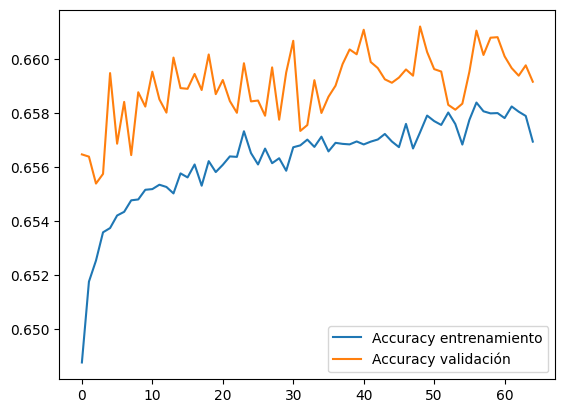

In [62]:
red = Sequential()

# Primera capa
red.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
red.add(Dropout(0.1))

# Segunda capa
red.add(LSTM(units = 100, return_sequences = False))
red.add(Dropout(0.1))
red.add(Dense(units = 5,activation = 'softmax'))

# Compilación de la red
red.compile(optimizer = 'adam',loss='CategoricalCrossentropy',metrics = ['accuracy'])

# Optimización del modelo
Early_Stopping = EarlyStopping(monitor='val_loss',patience=15, verbose=1,restore_best_weights=True)

# Entrenamiento de la red
historial = red.fit(x_train,y_train,epochs = 100, batch_size = 40, validation_data=(x_test,y_test),callbacks = [Early_Stopping])

# Predicción
y_pred = red.predict(x_test)

# Evaluación del modelo
perdida, accuracy = red.evaluate(x_test,y_test)
print(f'Pérdida del conjunto de test: {perdida}')
print(f'Accuracy del conjunto de test: {accuracy}')

# Visualización de los resultados
plt.plot(historial.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Accuracy validación')
plt.legend()
plt.show()

In [63]:
# Matriz de confusión
# Discretizaar los valores por filas
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
matriz_confusion = confusion_matrix(y_test, y_pred)
print('Matriz de confusión:')
print(matriz_confusion)

# Sensibilidad
sensibilidad = Sensibilidad(matriz_confusion)
print(f'Sensibilidad: {round(sensibilidad,4)}')
# Especificidad
especificidad = Especificidad(matriz_confusion)
print(f'Especificidad: {round(especificidad,4)}')

Matriz de confusión:
[[ 3613  1039    38 18644    56]
 [  400  8798   244  8393    95]
 [   69  2958   531  1752     3]
 [ 2092  3304   177 89538   650]
 [  160   587    28 12478   845]]
Sensibilidad: 0.6603
Especificidad: 0.9151


## LSTM con 10 ventanas y aumento de capas LSTM

In [64]:
ventana = 10
x = []
y = []
for i in range(ventana,len(X)):
  x.append(X[i-ventana:i,:])
  y.append(Y[i])

# Conversión de x e y en arrays de numpy para que la red neuronal los coja correctamente.
x,y = np.array(x), np.array(y)

# División en conjuntos de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.25, random_state= 0)

Epoch 1/100


c:\Users\sonia\OneDrive\Documentos\ESCRITORIO\3. MASTER\1. TFM\TFM\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11737/11737 ━━━━━━━━━━━━━━━━━━━━ 269s 23ms/step - accuracy: 0.6449 - loss: 0.9842 - val_accuracy: 0.6534 - val_loss: 0.9518
Epoch 2/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 266s 23ms/step - accuracy: 0.6511 - loss: 0.9550 - val_accuracy: 0.6556 - val_loss: 0.9405
Epoch 3/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 265s 23ms/step - accuracy: 0.6529 - loss: 0.9488 - val_accuracy: 0.6569 - val_loss: 0.9396
Epoch 4/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 266s 23ms/step - accuracy: 0.6535 - loss: 0.9470 - val_accuracy: 0.6556 - val_loss: 0.9367
Epoch 5/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 263s 22ms/step - accuracy: 0.6543 - loss: 0.9435 - val_accuracy: 0.6573 - val_loss: 0.9360
Epoch 6/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 268s 23ms/step - accuracy: 0.6556 - loss: 0.9405 - val_accuracy: 0.6579 - val_loss: 0.9339
Epoch 7/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 310s 22ms/step - accuracy: 0.6548 - loss: 0.9404 - val_accuracy: 0.6588 - val_loss: 0.9314
Epoch 8/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 269s 23ms/step 

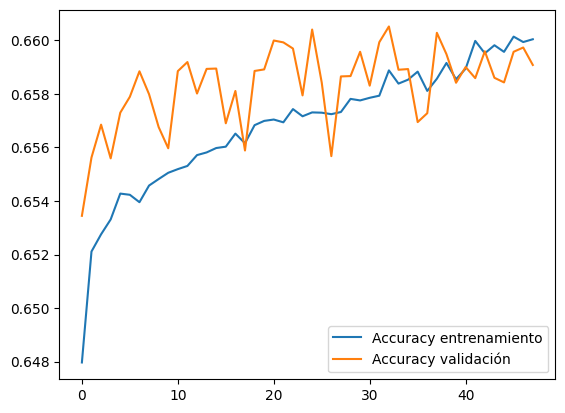

In [65]:
red = Sequential()

# Primera capa
red.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
red.add(Dropout(0.1))

# Segunda capa
red.add(LSTM(units = 100, return_sequences = True))
red.add(Dropout(0.1))

# Tercera capa
red.add(LSTM(units = 100, return_sequences = True))
red.add(Dropout(0.1))

# Cuarta capa
red.add(LSTM(units = 100, return_sequences = False))
red.add(Dropout(0.1))
red.add(Dense(units = 5,activation = 'softmax'))

# Compilación de la red
red.compile(optimizer = 'adam',loss='CategoricalCrossentropy',metrics = ['accuracy'])

# Optimización del modelo
Early_Stopping = EarlyStopping(monitor='val_loss',patience=15, verbose=1,restore_best_weights=True)

# Entrenamiento de la red
historial = red.fit(x_train,y_train,epochs = 100, batch_size = 40, validation_data=(x_test,y_test),callbacks = [Early_Stopping])

# Predicción
y_pred = red.predict(x_test)

# Evaluación del modelo
perdida, accuracy = red.evaluate(x_test,y_test)
print(f'Pérdida del conjunto de test: {perdida}')
print(f'Accuracy del conjunto de test: {accuracy}')

# Visualización de los resultados
plt.plot(historial.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Accuracy validación')
plt.legend()
plt.show()

In [66]:
# Matriz de confusión
# Discretizaar los valores por filas
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
matriz_confusion = confusion_matrix(y_test, y_pred)
print('Matriz de confusión:')
print(matriz_confusion)

# Sensibilidad
sensibilidad = Sensibilidad(matriz_confusion)
print(f'Sensibilidad: {round(sensibilidad,4)}')
# Especificidad
especificidad = Especificidad(matriz_confusion)
print(f'Especificidad: {round(especificidad,4)}')

Matriz de confusión:
[[ 5069  1166    36 17065    54]
 [  699  9198   280  7666    87]
 [  129  3006   537  1639     2]
 [ 3494  3769   195 87759   544]
 [  249   683    27 12336   803]]
Sensibilidad: 0.6605
Especificidad: 0.9151


## LSTM con 10 ventanas y 100 epochs + CNN

In [67]:
ventana = 10
x = []
y = []
for i in range(ventana,len(X)):
  x.append(X[i-ventana:i,:])
  y.append(Y[i])

# Conversión de x e y en arrays de numpy para que la red neuronal los coja correctamente.
x,y = np.array(x), np.array(y)

# División en conjuntos de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.25, random_state= 0)

Epoch 1/100


c:\Users\sonia\OneDrive\Documentos\ESCRITORIO\3. MASTER\1. TFM\TFM\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11737/11737 ━━━━━━━━━━━━━━━━━━━━ 92s 8ms/step - accuracy: 0.6347 - loss: 1.0218 - val_accuracy: 0.6360 - val_loss: 0.9844
Epoch 2/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.6351 - loss: 0.9905 - val_accuracy: 0.6479 - val_loss: 0.9915
Epoch 3/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 123s 6ms/step - accuracy: 0.6415 - loss: 0.9885 - val_accuracy: 0.6479 - val_loss: 0.9636
Epoch 4/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - accuracy: 0.6437 - loss: 0.9772 - val_accuracy: 0.6498 - val_loss: 0.9593
Epoch 5/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 89s 8ms/step - accuracy: 0.6415 - loss: 0.9803 - val_accuracy: 0.6489 - val_loss: 0.9610
Epoch 6/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.6451 - loss: 0.9761 - val_accuracy: 0.6498 - val_loss: 0.9736
Epoch 7/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 89s 8ms/step - accuracy: 0.6435 - loss: 0.9766 - val_accuracy: 0.6459 - val_loss: 0.9601
Epoch 8/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.6

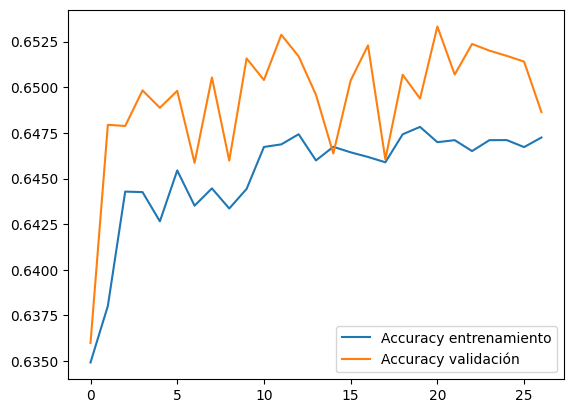

In [68]:
red = Sequential()

# Primera capa
red.add(Conv1D(filters= 100, kernel_size= 2, activation= 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
red.add(Dropout(0.1))

# Segunda capa
red.add(LSTM(units = 100, return_sequences = False))
red.add(Dropout(0.1))
red.add(Dense(units = 5,activation = 'softmax'))

# Compilación de la red
red.compile(optimizer = 'adam',loss='CategoricalCrossentropy',metrics = ['accuracy'])

# Optimización del modelo
Early_Stopping = EarlyStopping(monitor='val_loss',patience=15, verbose=1,restore_best_weights=True)

# Entrenamiento de la red
historial = red.fit(x_train,y_train,epochs = 100, batch_size = 40, validation_data=(x_test,y_test),callbacks = [Early_Stopping])

# Predicción
y_pred = red.predict(x_test)

# Evaluación del modelo
perdida, accuracy = red.evaluate(x_test,y_test)
print(f'Pérdida del conjunto de test: {perdida}')
print(f'Accuracy del conjunto de test: {accuracy}')

# Visualización de los resultados
plt.plot(historial.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Accuracy validación')
plt.legend()
plt.show()

In [69]:
# Matriz de confusión
# Discretizaar los valores por filas
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
matriz_confusion = confusion_matrix(y_test, y_pred)
print('Matriz de confusión:')
print(matriz_confusion)

# Sensibilidad
sensibilidad = Sensibilidad(matriz_confusion)
print(f'Sensibilidad: {round(sensibilidad,4)}')
# Especificidad
especificidad = Especificidad(matriz_confusion)
print(f'Especificidad: {round(especificidad,4)}')

Matriz de confusión:
[[ 3511   918     0 18961     0]
 [  367  8870     0  8693     0]
 [   68  3472     0  1773     0]
 [ 2542  3429     0 89789     1]
 [  170   636     0 13292     0]]
Sensibilidad: 0.6529
Especificidad: 0.9132


## CNN

In [70]:
ventana = 10
x = []
y = []
for i in range(ventana,len(X)):
  x.append(X[i-ventana:i,:])
  y.append(Y[i])

# Conversión de x e y en arrays de numpy para que la red neuronal los coja correctamente.
x,y = np.array(x), np.array(y)

# División en conjuntos de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.25, random_state= 0)

Epoch 1/100


c:\Users\sonia\OneDrive\Documentos\ESCRITORIO\3. MASTER\1. TFM\TFM\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11737/11737 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.5819 - loss: 66.1201 - val_accuracy: 0.6119 - val_loss: 1.1648
Epoch 2/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.6097 - loss: 1.1708 - val_accuracy: 0.6119 - val_loss: 1.1651
Epoch 3/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.6109 - loss: 1.1688 - val_accuracy: 0.6119 - val_loss: 1.1664
Epoch 4/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.6101 - loss: 1.1700 - val_accuracy: 0.6119 - val_loss: 1.1648
Epoch 5/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.6116 - loss: 1.1668 - val_accuracy: 0.6119 - val_loss: 1.1647
Epoch 6/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.6106 - loss: 1.1684 - val_accuracy: 0.6119 - val_loss: 1.1659
Epoch 7/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.6112 - loss: 1.1667 - val_accuracy: 0.6119 - val_loss: 1.1646
Epoch 8/100
11737/11737 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.6

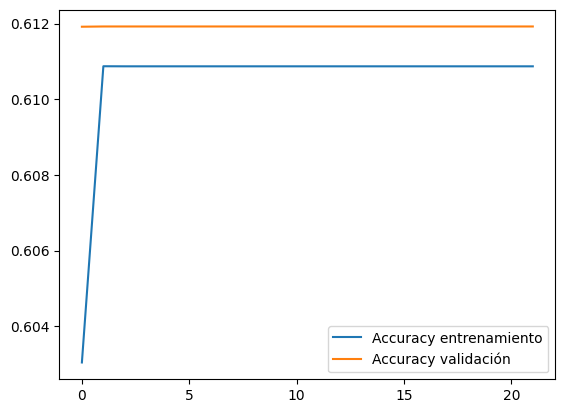

In [71]:
# Creación de la red CNN
CNN = Sequential()

# Primera capa convolux¡cional
CNN.add(Conv1D(filters= 100, kernel_size= 2,activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[2])))
CNN.add(Dropout(0.1))

# Segunda capa convolucional
CNN.add(Conv1D(filters= 100, kernel_size= 2))
CNN.add(Dropout(0.1))

# Aplanamiento
CNN.add(Flatten())

# Capa de salida
CNN.add(Dense(units = 5,activation = 'softmax'))

# Compilación de la red
CNN.compile(optimizer = 'adam', loss = 'CategoricalCrossentropy', metrics = ['accuracy'])

# Optimización del modelo
Early_Stopping = EarlyStopping(monitor='val_loss',patience=15, verbose=1,restore_best_weights=True)

# Entrenamiento de la red
historial = CNN.fit(x_train,y_train,epochs = 100, batch_size = 40, validation_data=(x_test,y_test),callbacks = [Early_Stopping])

# Predicción
y_pred = CNN.predict(x_test)

# Evaluación del modelo
perdida, accuracy = CNN.evaluate(x_test,y_test)
print(f'Pérdida del conjunto de test: {perdida}')
print(f'Accuracy del conjunto de test: {accuracy}')

# Visualización de los resultados
plt.plot(historial.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Accuracy validación')
plt.legend()
plt.show()

In [72]:
# Matriz de confusión
# Discretizaar los valores por filas
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
matriz_confusion = confusion_matrix(y_test, y_pred)
print('Matriz de confusión:')
print(matriz_confusion)

# Sensibilidad
sensibilidad = Sensibilidad(matriz_confusion)
print(f'Sensibilidad: {round(sensibilidad,4)}')
especificidad = Especificidad(matriz_confusion)
print(f'Especificidad: {round(especificidad,4)}')

Matriz de confusión:
[[    0     0     0 23390     0]
 [    0     0     0 17930     0]
 [    0     0     0  5313     0]
 [    0     0     0 95761     0]
 [    0     0     0 14098     0]]
Sensibilidad: 0.6119
Especificidad: 0.903
